In [1]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

## 03. 앙상블 학습

이미지, 영상, 음성 등 비정형 데이터의 분류 → 딥러닝  
대부분의 정형 데이터 분류 → 앙상블

#### 앙상블의 학습 유형
- 보팅(Voting), 배깅(Bagging), 부스팅(Boosting) + 스태킹(stacking)
- 보팅(Voting) : 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정, 일반적으로 서로 다른 알고리즘을 가진 분류기를 결합
- 배깅(Bagging) : 보팅과 마찬가지로 여러 개의 분류기의 다수결에 따라 최종 예측 결과를 결정, 모두 같은 알고리즘을 가진 분류기를 결합하지만 데이터 샘플링을 서로 다르게, 중첩을 허용 (예) 랜덤포레스트
    - 개별 분류기에 데이터를 샘플링해서 추출하는 방식을 부트스트래핑(Bootstrapping) 분할 방식이라고 부름
- 부스팅(Boosting) : 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터 대해서 올바르게 예측할 수 있도록 다음 분류기에 가중치를 부여하면서 학습과 예측을 진행 (예) XGBoost, LightGBM

*Q. 보팅은 원본 데이터 셋의 모든 데이터를 사용하는 것인가?  
A. 모든 데이터를 사용한다.*

#### 보팅 유형
- 하드 보팅(Hard Voting) : 다수결
- 소프트 보팅(Soft Voting) : 분류기들의 레이블 값 결정 확률(proba)을 모두 더하여 이를 평균해서 이들 중 확률이 가장 높은 레이블 값을 최종 보팅 결과값으로 선정, 하드 보팅보다 예측 성능이 좋아서 일반적인 보팅 방식으로 사용

### 보팅 분류기 (Voting Classifier)
#### 인자
- estimator : 모델 입력
- voting : 보팅 방식 설정 (soft/hard)

#### 주의할 점
- 여러 개의 base classifier을 결합한다고 해서 무조건 base classifier보다 예측 성능이 향상되지는 않음
- 데이터의 특성과 분포 등 다양한 요건에 따라 다름
> ML 모델의 성능은 어떻게 높은 유연성을 가지고 현실에 대처할 수 있는가가 중요한 평가요소

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:

knn = KNeighborsClassifier()
lr = LogisticRegression()
vo = VotingClassifier(estimators = [('knn', knn), ('lr', lr)], voting='soft')

X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=156)

vo.fit(X_train, y_train)
pred = vo.predict(X_test)
print(vo.__class__.__name__, accuracy_score(y_test, pred))

classifiers = [knn, lr]

for cf in classifiers :
    cf.fit(X_train, y_train)
    pred = cf.predict(X_test)
    cf_name = cf.__class__.__name__
    print(cf_name, accuracy_score(y_test, pred))
    

VotingClassifier 0.9473684210526315
KNeighborsClassifier 0.9035087719298246
LogisticRegression 0.9385964912280702


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

## 04. 랜덤 포레스트
- 여러 개의 결정 트리 분류기가 전체 데이터에서 Bagging 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측 결정

#### 부트스트래핑(bootstrapping) = 줄여서 bagging
하나의 원본 데이터 세트로부터 여러 개의 데이터 세트를 중첩되게 분리하는 방식

*Q. 랜덤포레스트의 보팅 방식???*

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=156)
rf_clf.fit(X_train, y_train)
pred_proba = rf_clf.predict_proba(X_test)
print(X_test.shape)
print(pred_proba.shape)
pred_proba

(114, 30)
(114, 2)


array([[0.17, 0.83],
       [0.97, 0.03],
       [0.39, 0.61],
       [0.6 , 0.4 ],
       [0.03, 0.97],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.02, 0.98],
       [1.  , 0.  ],
       [0.95, 0.05],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.1 , 0.9 ],
       [0.12, 0.88],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.98, 0.02],
       [0.6 , 0.4 ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.31, 0.69],
       [0.96, 0.04],
       [0.99, 0.01],
       [0.02, 0.98],
       [0.95, 0.05],
       [0.  , 1.  ],
       [0.96, 0.04],
       [0.06, 0.94],
       [0.36, 0.64],
       [0.94, 0.06],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.02, 0.98],
       [0.68, 0.32],
       [0.  , 1.  ],
       [0.61, 0.39],
       [0.09, 0.91],
       [0.01, 0.99],
       [0.05, 0.95],
       [0.  , 1.  ],
       [0.2 , 0.8 ],
       [0.89, 0.11],
       [0.  ,

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore')


X_train, X_test,  y_train, y_test = get_human_dataset()

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred =rf.predict(X_test)
print(rf.__class__.__name__, accuracy_score(y_test, pred))

RandomForestClassifier 0.9246691550729556


### 랜덤포레스트 하이퍼 파라미터 및 튜닝
```
class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)[source]¶
```


- `n_estimators` : 개별 결정 트리의 갯수, default = 100
- `max_features ` : 개별 결정 트리에 사용되는 피처의 최대 갯수, default = 'auto'(sqrt)
- `max_depth`
- `min_samples_leaf`

*Q. 랜덤포레스트 모델에서 n_jobs와, GridSearchCV에서 n_jobs가 어떤 의미로 다르지???  
A. 랜덤포레스트 모델에서 n_jobs는 개별 결정 트리를 돌리는 데 사용하는 cpu?의 수, GridSearchCV는?*


In [6]:
# estimator에 가능한 parameter 목록
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [12]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20],
}

rf = RandomForestClassifier(random_state=0, n_jobs=-1) #
grid_rf = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1) 
grid_rf.fit(X_train, y_train)

print("최적의 hyper-params : ", grid_rf.best_params_)
print("최고 예측 정확도 : ", grid_rf.best_score_)

최적의 hyper-params :  {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 :  0.9179815016322089


In [16]:
rf_best = RandomForestClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=8, n_estimators=100)
rf_best.fit(X_train, y_train)
pred = rf_best.predict(X_test)
print(accuracy_score(y_test, pred))

0.9209365456396336


### Feature Importance

<AxesSubplot:xlabel='values'>

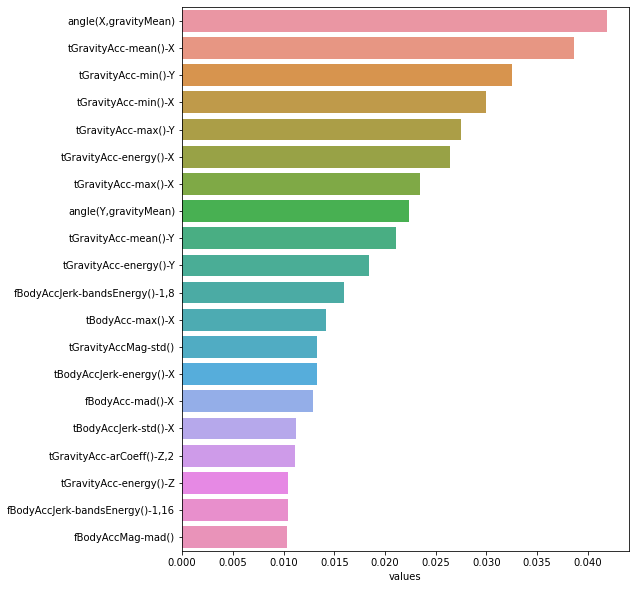

In [32]:
ftr_importance_values = rf_best.feature_importances_
ftr_importance = pd.DataFrame(ftr_importance_values, index=X_train.columns, columns=['values'])
ftr_top20 = ftr_importance.sort_values("values",ascending=False).iloc[:20,0]

plt.figure(figsize=(8,10))
sns.barplot(x=ftr_top20, y=ftr_top20.index)